In [ ]:
#mounting drive with colab
from google.colab import drive
drive.mount('/content/drive') 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
#change directory to project
import os
os.chdir('/content/drive/My Drive/SEM 2/mini project/cityscapes/tfrecord')
print(os.getcwd())

/content/drive/My Drive/SEM 2/mini project/cityscapes/tfrecord


In [ ]:
!ls

model.png		       val-00000-of-00010.tfrecord
train-00000-of-00010.tfrecord  val-00001-of-00010.tfrecord
train-00001-of-00010.tfrecord  val-00002-of-00010.tfrecord
train-00002-of-00010.tfrecord  val-00003-of-00010.tfrecord
train-00003-of-00010.tfrecord  val-00004-of-00010.tfrecord
train-00004-of-00010.tfrecord  val-00005-of-00010.tfrecord
train-00005-of-00010.tfrecord  val-00006-of-00010.tfrecord
train-00006-of-00010.tfrecord  val-00007-of-00010.tfrecord
train-00007-of-00010.tfrecord  val-00008-of-00010.tfrecord
train-00008-of-00010.tfrecord  val-00009-of-00010.tfrecord
train-00009-of-00010.tfrecord


In [ ]:
!pip install tensorflow-gpu==2.2.0-alpha0
!pip install tensorflow==2.2.0-alpha0

In [ ]:
!pip install --upgrade tensorflow
# change the hardware accelerator to GPU in EDIT > NOTEBOOK SETTINGS.

In [ ]:
!pip show tensorflow
import tensorflow as tf

Name: tensorflow
Version: 2.2.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: google-pasta, grpcio, numpy, absl-py, tensorflow-estimator, scipy, tensorboard, keras-preprocessing, six, protobuf, astunparse, h5py, opt-einsum, gast, wrapt, termcolor, wheel
Required-by: fancyimpute


In [ ]:
# model building as functions

def conv_block(inputs, conv_type, kernel, kernel_size, strides, padding='same', relu=True):
  
  if(conv_type == 'ds'):
    x = tf.keras.layers.SeparableConv2D(kernel, kernel_size, padding=padding, strides = strides)(inputs)
  else:
    x = tf.keras.layers.Conv2D(kernel, kernel_size, padding=padding, strides = strides)(inputs)  
  
  x = tf.keras.layers.BatchNormalization()(x)
  
  if (relu):
    x = tf.keras.activations.relu(x)
  
  return x

def _res_bottleneck(inputs, filters, kernel, t, s, r=False):
    
    
    tchannel = tf.keras.backend.int_shape(inputs)[-1] * t

    x = conv_block(inputs, 'conv', tchannel, (1, 1), strides=(1, 1))

    x = tf.keras.layers.DepthwiseConv2D(kernel, strides=(s, s), depth_multiplier=1, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)

    x = conv_block(x, 'conv', filters, (1, 1), strides=(1, 1), padding='same', relu=False)

    if r:
        x = tf.keras.layers.add([x, inputs])
    return x

"""#### Bottleneck custom method"""

def bottleneck_block(inputs, filters, kernel, t, strides, n):
  x = _res_bottleneck(inputs, filters, kernel, t, strides)
  
  for i in range(1, n):
    x = _res_bottleneck(x, filters, kernel, t, 1, True)

  return x

"""#### PPM Method"""

def pyramid_pooling_block(input_tensor, bin_sizes):
  concat_list = [input_tensor]
  w = 64
  h = 32

  for bin_size in bin_sizes:
    x = tf.keras.layers.AveragePooling2D(pool_size=(w//bin_size, h//bin_size), strides=(w//bin_size, h//bin_size))(input_tensor)
    x = tf.keras.layers.Conv2D(128, 3, 2, padding='same')(x)
    x = tf.keras.layers.Lambda(lambda x: tf.image.resize(x, (w,h)))(x)

    concat_list.append(x)

  return tf.keras.layers.concatenate(concat_list)

Model: "Fast_SCNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 2048, 1024,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 1024, 512, 32 896         input_layer[0][0]                
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 1024, 512, 32 128         conv2d[0][0]                     
__________________________________________________________________________________________________
tf_op_layer_Relu (TensorFlowOpL [(None, 1024, 512, 3 0           batch_normalization[0][0]        
__________________________________________________________________________________________

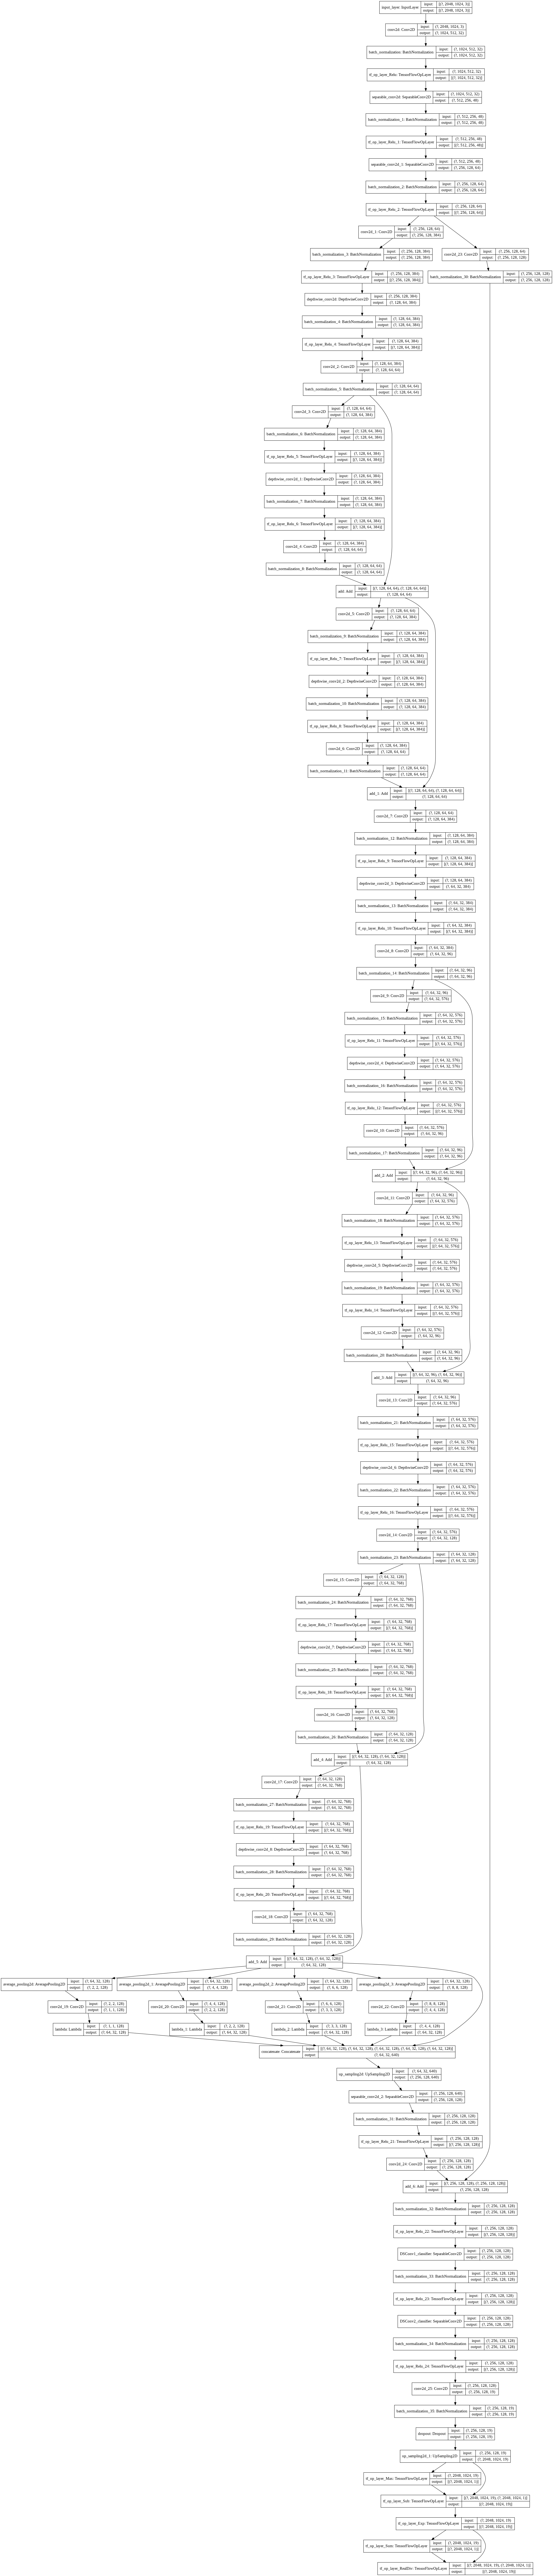

In [ ]:
# Step 1: Learning to DownSample
# Input Layer
input_layer = tf.keras.layers.Input(shape=(2048, 1024, 3), name = 'input_layer')

lds_layer = conv_block(input_layer, 'conv', 32, (3, 3), strides = (2, 2))
lds_layer = conv_block(lds_layer, 'ds', 48, (3, 3), strides = (2, 2))
lds_layer = conv_block(lds_layer, 'ds', 64, (3, 3), strides = (2, 2))

# Step 2: Global Feature Extractor
#### residual custom method
# Assembling all the methods"
gfe_layer = bottleneck_block(lds_layer, 64, (3, 3), t=6, strides=2, n=3)
gfe_layer = bottleneck_block(gfe_layer, 96, (3, 3), t=6, strides=2, n=3)
gfe_layer = bottleneck_block(gfe_layer, 128, (3, 3), t=6, strides=1, n=3)
gfe_layer = pyramid_pooling_block(gfe_layer, [2,4,6,8])

# Step 3: Feature Fusion

ff_layer1 = conv_block(lds_layer, 'conv', 128, (1,1), padding='same', strides= (1,1), relu=False)

ff_layer2 = tf.keras.layers.UpSampling2D((4, 4))(gfe_layer)
ff_layer2 = tf.keras.layers.SeparableConv2D(128, (3, 3), padding='same', strides = (1, 1), activation=None, dilation_rate=(4, 4))(ff_layer2)

ff_layer2 = tf.keras.layers.BatchNormalization()(ff_layer2)
ff_layer2 = tf.keras.activations.relu(ff_layer2)
ff_layer2 = tf.keras.layers.Conv2D(128, 1, 1, padding='same', activation=None)(ff_layer2)

ff_final = tf.keras.layers.add([ff_layer1, ff_layer2])
ff_final = tf.keras.layers.BatchNormalization()(ff_final)
ff_final = tf.keras.activations.relu(ff_final)

# Step 4: Classifier
classifier = tf.keras.layers.SeparableConv2D(128, (3, 3), padding='same', strides = (1, 1), name = 'DSConv1_classifier')(ff_final)
classifier = tf.keras.layers.BatchNormalization()(classifier)
classifier = tf.keras.activations.relu(classifier)

classifier = tf.keras.layers.SeparableConv2D(128, (3, 3), padding='same', strides = (1, 1), name = 'DSConv2_classifier')(classifier)
classifier = tf.keras.layers.BatchNormalization()(classifier)
classifier = tf.keras.activations.relu(classifier)


classifier = conv_block(classifier, 'conv', 19, (1, 1), strides=(1, 1), padding='same', relu=False)
classifier = tf.keras.layers.Dropout(0.3)(classifier)

classifier = tf.keras.layers.UpSampling2D((8, 8))(classifier)
classifier = tf.keras.activations.softmax(classifier)

# Model Compilation
fast_scnn = tf.keras.Model(inputs = input_layer , outputs = classifier, name = 'Fast_SCNN')
optimizer = tf.keras.optimizers.SGD(momentum=0.9, lr=0.045)
fast_scnn.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

fast_scnn.summary()

tf.keras.utils.plot_model(fast_scnn, show_layer_names=True, show_shapes=True)

In [ ]:
def _parse_function(proto):
    # define your tfrecord again. Remember that you saved your image as a string.
    keys_to_features = {'image': tf.FixedLenFeature([], tf.string),
                        "label": tf.FixedLenFeature([], tf.int64)}
    
    # Load one example
    parsed_features = tf.parse_single_example(proto, keys_to_features)
    
    # Turn your saved image string into an array
    parsed_features['image'] = tf.decode_raw(
        parsed_features['image'], tf.uint8)
    
    return parsed_features['image'], parsed_features["label"]

  
def create_dataset(filepath):
    
    # This works with arrays as well
    dataset = tf.data.TFRecordDataset(filepath)
    
    # Maps the parser on every filepath in the array. You can set the number of parallel loaders here
    dataset = dataset.map(_parse_function, num_parallel_calls=8)
    
    # This dataset will go on forever
    dataset = dataset.repeat()
    
    # Set the number of datapoints you want to load and shuffle 
    dataset = dataset.shuffle(SHUFFLE_BUFFER)
    
    # Set the batchsize
    #dataset = dataset.batch(BATCH_SIZE)
    
    # Create an iterator
    iterator = dataset.make_one_shot_iterator()
    
    # Create your tf representation of the iterator
    image, label = iterator.get_next()

    # Bring your picture back in shape
    #image = tf.reshape(image, [-1, 256, 256, 1])
    
    # Create a one hot array for your labels
    #label = tf.one_hot(label, NUM_CLASSES)
    
    return image, label

In [ ]:
dataset = tf.data.TFRecordDataset("train-00000-of-00010.tfrecord")

In [ ]:
dir(dataset)

['_GeneratorState',
 '__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_cache',
 '_abc_negative_cache',
 '_abc_negative_cache_version',
 '_abc_registry',
 '_add_variable_with_custom_getter',
 '_apply_options',
 '_as_serialized_graph',
 '_buffer_size',
 '_checkpoint_dependencies',
 '_clone',
 '_compression_type',
 '_consumers',
 '_deferred_dependencies',
 '_filenames',
 '_flat_shapes',
 '_flat_structure',
 '_flat_types',
 '_functions',
 '_gather_saveables_for_checkpoint',
 '_graph',
 '_graph_attr',
 '_handle_deferred_dependencies',
 '_has_captured_ref',
 '_impl',
 '_inputs',
 '_list_extra_dependencies_for_serialization',
 '_list_fu

In [ ]:
dataset.__repr__

<bound method DatasetV2.__repr__ of <TFRecordDatasetV2 shapes: (), types: tf.string>>